# The Exploration of Daniel Bourke's Youtube Channel - My First Data Project

## Introduction
In this notebook, we are going to explore [Daniel Bourke's YouTube channel](https://www.youtube.com/channel/UCr8O8l5cCX85Oem1d18EezQ "mrdbourke").

Daniel Bourke is a machine learning engineer and content creator.

I came across an idea for this when I was browsing his YouTube channel. I noticed that he had two distinct topics: machine learning and fitness.

Then, the thought came to me.

I wonder how the popularity of his machine learning videos would compared to his fitness related videos. And so begins this project.

As with any project, this is a learning oppourtunity to improve my skills in coding and dealing with data. This being my first means I have lots to learn!

## Aims
- Pull data from YouTube Data API v3 to get upload playlist and the individual video statistics for Daniel Bourke's youtube channel.
- Classify his videos between machine learning and fitness/health - somehow.
- Come up with some way of visualising the difference in popularity (based on view count)

## Resources

- [Setting up Google API Client](https://developers.google.com/docs/api/quickstart/python)
- [Google Console](https://console.developers.google.com/)
- [YouTube Data API v3 Documentation](https://developers.google.com/youtube/v3)

## Let's Get Started

Most libraries are the stock standard, included in the Anaconda distribution.

You will need to install the [Google API Client library for Python](https://developers.google.com/docs/api/quickstart/python).

This can be done simply using `conda install google-api-python-client`

In addition to this, I have also included `conda install isodate`



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as r
import seaborn as sns

%matplotlib inline

import os
import requests
import math
import re
import isodate

from datetime import date, time, datetime

import googleapiclient.discovery
import googleapiclient.errors



## Access the YouTube API

You will need to head over to the [Google Console to create a project](https://console.developers.google.com/).

This will give you an API key. Make sure you copy this. I have created a seperate Python file, `setAPIkey.py` that saves the API key to an environment variable, `YT_API`. This file sits in `.gitignore` so it doesn't accidently appear on my github!

Here is the code for `setAPIkey.py`:
```python
#!python3

import os
os.environ['YT_API'] = 'xxAPI KEY HERExx'
```



In [2]:
%run setAPIkey.py

api_service_name = 'youtube'
api_version = 'v3'
youtube = googleapiclient.discovery.build(api_service_name, api_version, developerKey=os.getenv('YT_API'))



## Access the Daniel Bourke's Channel

We are going to access the upload playlist ID which contains all uploaded videos on Daniel Bourke's channel. We do this by using the `channels().list()` method.

This is going to be stored in `uploadPlaylist_ID`

[More documentation on this method, here.](https://developers.google.com/youtube/v3/docs/channels/list)



In [3]:
channel_ID = 'UCr8O8l5cCX85Oem1d18EezQ' # Daniel Bourke's channel ID

channel_request = youtube.channels().list(
    part='snippet,contentDetails',
    id=channel_ID
)
channel_res = channel_request.execute()
channel_res

{'kind': 'youtube#channelListResponse',
 'etag': 'xaqUNTC2ZtEfkWOssAXuy7EtWZo',
 'pageInfo': {'resultsPerPage': 1},
 'items': [{'kind': 'youtube#channel',
   'etag': 'hn79H0m-K3PIGztc7HX-w1XdZQo',
   'id': 'UCr8O8l5cCX85Oem1d18EezQ',
   'snippet': {'title': 'Daniel Bourke',
    'description': "I'm a machine learning engineer who plays at the intersection of technology and health.\n\nMy videos will help you learn better and live healthier.\n\nFeel free to introduce yourself, I'd love to hear from you.\n\nDaniel",
    'publishedAt': '2016-08-02T21:36:26Z',
    'thumbnails': {'default': {'url': 'https://yt3.ggpht.com/a/AATXAJwKBdy84WKVUIoOt37SBAeWjUhPdGDAx9WxNt1Rdz4=s88-c-k-c0xffffffff-no-rj-mo',
      'width': 88,
      'height': 88},
     'medium': {'url': 'https://yt3.ggpht.com/a/AATXAJwKBdy84WKVUIoOt37SBAeWjUhPdGDAx9WxNt1Rdz4=s240-c-k-c0xffffffff-no-rj-mo',
      'width': 240,
      'height': 240},
     'high': {'url': 'https://yt3.ggpht.com/a/AATXAJwKBdy84WKVUIoOt37SBAeWjUhPdGDAx9WxN

In [4]:
uploadPlaylist_ID = channel_res['items'][0]['contentDetails']['relatedPlaylists']['uploads']

## Get the list of Video IDs

Precisely as the title says, let's get those video IDs in a list. We are going to use a similiar method, `playlistItems().list()`. [More information, here](https://developers.google.com/youtube/v3/docs/playlistItems/list)

We can request 50 video IDs at a time. A `pageToken` variable is given that allows us to access the next lot of 50 videos. I'm going to write this as a funciton and call it `playlist_requester()` since I will be calling it multiple times.

In [5]:
def playlist_requester(pageToken=None,uploadPlaylist_ID=uploadPlaylist_ID):
    playlist_request = youtube.playlistItems().list(
        part='snippet,contentDetails',
        maxResults=50,
        pageToken=pageToken,
        playlistId=uploadPlaylist_ID
    )
    playlist_res = playlist_request.execute()
    
    return playlist_res



I run the function once to get the total number of videos in this playlist and the first pageToken variable.

What I also do is create a list of just the video IDs, which is the only thing relevant. I use a list comprehension to do this.



In [6]:
playlist_res = playlist_requester()

TOTAL_UPLOADS = playlist_res['pageInfo']['totalResults'] # total videos in upload playslist
nextPageToken = playlist_res['nextPageToken'] # needed to access the next page

listOfVideo_IDs = [ video_ID['contentDetails']['videoId'] for video_ID in playlist_res['items'] ] # first 50



Then, I create a while loop to get all the video IDs into a list.



In [7]:
while TOTAL_UPLOADS > len(listOfVideo_IDs):
    
    nextpage_playlist_res = playlist_requester(nextPageToken)
    listOfVideo_IDs.extend([ video_ID['contentDetails']['videoId'] for video_ID in nextpage_playlist_res['items'] 
                            if video_ID['contentDetails']['videoId'] not in listOfVideo_IDs ]) # extend() for lists / #append only does one item at ta time / concating lists with + is very intenstive according to "Python for Data Analysis"
    if 'nextPageToken' in nextpage_playlist_res:
        nextPageToken = nextpage_playlist_res['nextPageToken']
        
    print('Number of Uploaded Videos: ' + str(len(listOfVideo_IDs)))

Number of Uploaded Videos: 100
Number of Uploaded Videos: 150
Number of Uploaded Videos: 200
Number of Uploaded Videos: 250
Number of Uploaded Videos: 256


## Get the Video Statistics

Finally after all of that we get the statistics for each video. I use a for loop to run through the list generated earlier.

Similiar to `playlistItems().list()`, I can use `videos().list()` to request 50 videos at a time.

The output will combined together using another list comprehension.

We imported the `math` library earlier. We are going to use the `ceil()` function to compute the number of '50 chuncks' out of the total list, rounding up. We also use list splicing to get each '50 chunk'.

We use `pd.json_normalize()` on our newly created list `video_response` to flatten the output provided, turning it into a pandas dataframe (fun fact: in New Zealand we use British English so we are used to using 's' instead of 'z' for normalize).

`df.head()` will provide us the first 5 video and their statistics. Hooray!

In [8]:
video_response = [ youtube.videos().list(
        part='snippet,contentDetails,statistics',
        id=listOfVideo_IDs[50*i:50*(i+1)]
    ).execute() for i in range(math.ceil(len(listOfVideo_IDs)/50)) ]

df = pd.json_normalize(video_response, 'items')

df.head()

,kind,etag,id,snippet.publishedAt,snippet.channelId,snippet.title,snippet.description,snippet.thumbnails.default.url,snippet.thumbnails.default.width,snippet.thumbnails.default.height,...,contentDetails.caption,contentDetails.licensedContent,contentDetails.projection,statistics.viewCount,statistics.likeCount,statistics.dislikeCount,statistics.favoriteCount,statistics.commentCount,snippet.defaultAudioLanguage,contentDetails.regionRestriction.blocked
0,youtube#video,pO2Fhfj6xWYzSnjWVhRhSnpIpfc,DBbBRwpneLs,2020-10-10T13:50:35Z,UCr8O8l5cCX85Oem1d18EezQ,Data scientists should be more end-to-end | Ma...,Every month I review the latest and greatest r...,https://i.ytimg.com/vi/DBbBRwpneLs/default.jpg,120,90,...,false,True,rectangular,1820,144,1,0,26,NaN,NaN
1,youtube#video,9vKtHGsTaDnfKd7ayYhYPzOZ7z8,POfdG7PZHkc,2020-10-05T05:22:14Z,UCr8O8l5cCX85Oem1d18EezQ,What skills should you learn outside of machin...,Every month or so I do a livestream where I da...,https://i.ytimg.com/vi/POfdG7PZHkc/default.jpg,120,90,...,false,True,rectangular,3669,158,6,0,23,NaN,NaN
2,youtube#video,bpAPBVQf7ZkpVG1ewBHo7204YnU,mN8G9fWOKP0,2020-09-19T05:23:13Z,UCr8O8l5cCX85Oem1d18EezQ,It's going to be a big (and fast) Summer of le...,From new Nvidia GPUs to using machine learning...,https://i.ytimg.com/vi/mN8G9fWOKP0/default.jpg,120,90,...,false,True,rectangular,23742,840,9,0,146,NaN,NaN
3,youtube#video,ZCRbItKhRI70KZR0aymQhbkjA3g,cZ2HCclgQ-g,2020-09-13T02:30:12Z,UCr8O8l5cCX85Oem1d18EezQ,How I'd start learning machine learning again ...,Three years ago I started studying machine lea...,https://i.ytimg.com/vi/cZ2HCclgQ-g/default.jpg,120,90,...,false,True,rectangular,36312,1829,29,0,157,NaN,NaN
4,youtube#video,Zita8C3t8QJD_L1eP14Zh60fsVQ,Nz7xzUybpFM,2020-09-06T10:58:18Z,UCr8O8l5cCX85Oem1d18EezQ,Building a Deep Learning PC,I've been thinking about building my own deep ...,https://i.ytimg.com/vi/Nz7xzUybpFM/default.jpg,120,90,...,false,True,rectangular,10456,416,6,0,145,NaN,NaN


## Exploring the Data

Let's do some exploring. We use `df.shape` to find out how many rows and columns exist in this dataframe `(rows, columns)`. The number of rows should equal the total videos uploaded on Daniel Bourke's YouTube channel since each row is one video.

We then use `df.dtypes` to see what the data types are for each column and also the explore what columns we have to play with.

In [9]:
df.shape

(256, 41)

In [10]:
df.dtypes

kind                                         object
etag                                         object
id                                           object
snippet.publishedAt                          object
snippet.channelId                            object
snippet.title                                object
snippet.description                          object
snippet.thumbnails.default.url               object
snippet.thumbnails.default.width              int64
snippet.thumbnails.default.height             int64
snippet.thumbnails.medium.url                object
snippet.thumbnails.medium.width               int64
snippet.thumbnails.medium.height              int64
snippet.thumbnails.high.url                  object
snippet.thumbnails.high.width                 int64
snippet.thumbnails.high.height                int64
snippet.thumbnails.standard.url              object
snippet.thumbnails.standard.width           float64
snippet.thumbnails.standard.height          float64
snippet.thum

We can see all the columns and data types. We can select the columns we can to keep. We also want to change them to the appropriate data type for further analysis and we can do this with `astype()`.

We can confirm this change running `dtypes()` again.

In [11]:
df1 = df[['snippet.title', 'snippet.tags', 'contentDetails.duration',
       'statistics.viewCount', 'statistics.likeCount', 'statistics.dislikeCount',
        'statistics.commentCount', 'snippet.publishedAt','snippet.description']]

df1 = df1.astype({'statistics.viewCount': 'float'})
df1 = df1.astype({'statistics.likeCount': 'float'})
df1 = df1.astype({'statistics.dislikeCount': 'float'})
df1 = df1.astype({'statistics.commentCount': 'float'})

We can also note that there are publish dates and times: `snippet.publishedAt` and `contentDetails.duration`. There need to be converted into a workable format.

In [12]:
df1['snippet.publishedAt_REFORMATED'] = df1['snippet.publishedAt'].apply(lambda x : datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ'))
df1['contentDetails.duration_REFORMATED'] = df1['contentDetails.duration'].apply(lambda x : isodate.parse_duration(x)) # Turns ISO8061 into duration that can be utilised by python

In [13]:
df1.head(2)

,snippet.title,snippet.tags,contentDetails.duration,statistics.viewCount,statistics.likeCount,statistics.dislikeCount,statistics.commentCount,snippet.publishedAt,snippet.description,snippet.publishedAt_REFORMATED,contentDetails.duration_REFORMATED
0,Data scientists should be more end-to-end | Ma...,"[machine learning monthly, how to get started ...",PT37M45S,1820.0,144.0,1.0,26.0,2020-10-10T13:50:35Z,Every month I review the latest and greatest r...,2020-10-10 13:50:35,0 days 00:37:45
1,What skills should you learn outside of machin...,"[machine learning engineer, daniel bourke, mac...",PT1H16M28S,3669.0,158.0,6.0,23.0,2020-10-05T05:22:14Z,Every month or so I do a livestream where I da...,2020-10-05 05:22:14,0 days 01:16:28


In [14]:
df1.dtypes

snippet.title                                  object
snippet.tags                                   object
contentDetails.duration                        object
statistics.viewCount                          float64
statistics.likeCount                          float64
statistics.dislikeCount                       float64
statistics.commentCount                       float64
snippet.publishedAt                            object
snippet.description                            object
snippet.publishedAt_REFORMATED         datetime64[ns]
contentDetails.duration_REFORMATED    timedelta64[ns]
dtype: object

Let's do some further exploration of the view counts. We are going to use the `matplotlib` library, along with `seaborn`.

C:\Users\Shiva\miniconda3\envs\shivan_environment\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


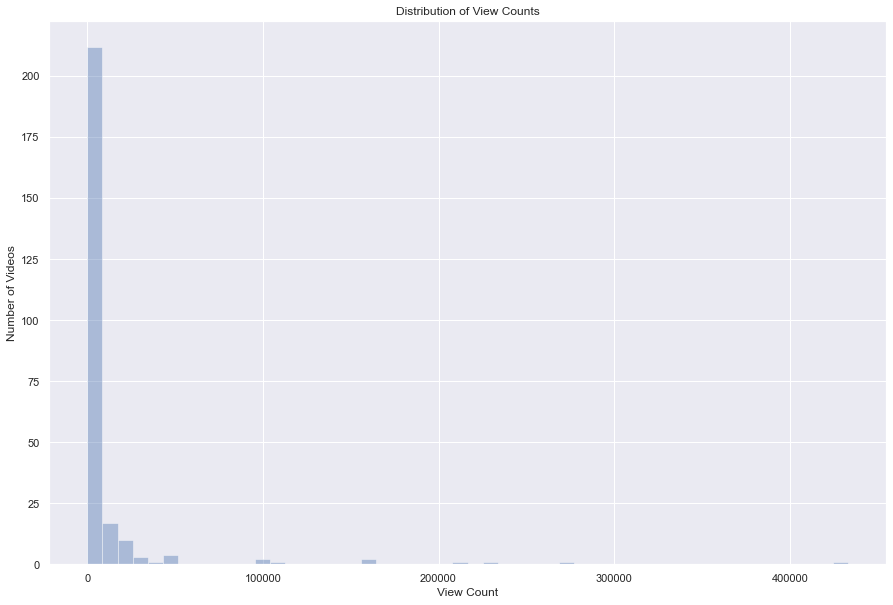

In [15]:
views = df1['statistics.viewCount']
sns.set(style='darkgrid')
plt.figure(figsize=(15,10))

ax = sns.distplot(views, kde=False)
labels = ax.set(title='Distribution of View Counts',xlabel='View Count', ylabel='Number of Videos')

We can see the majority of videos are well below 10,000 views, which goes to show how hard it is to be a content creator.

Its almost Pareto principle, where 20% or your content gives 80% of the rewards. We can confirm this:

In [16]:
vidsOver10000views = (df1['statistics.viewCount']<10000).sum()
totalVids = len(listOfVideo_IDs)
percentage = round(( vidsOver10000views * 100 ) /  totalVids,2)
print('Videos under 10,000 views: {} ({}%)'.format(str(vidsOver10000views),str(percentage)))

Videos under 10,000 views: 216 (84.38%)


C:\Users\Shiva\miniconda3\envs\shivan_environment\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


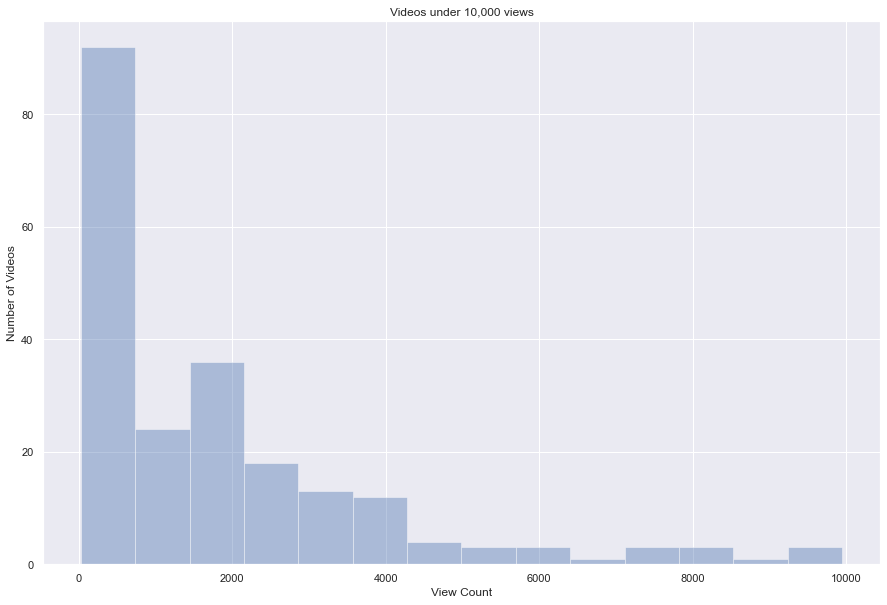

In [17]:
viewsU10000 = df1['statistics.viewCount'][df1['statistics.viewCount']<10000]
sns.set(style='darkgrid')
plt.figure(figsize=(15,10))

ax = sns.distplot(viewsU10000, kde=False)
labels = ax.set(title='Videos under 10,000 views',xlabel='View Count', ylabel='Number of Videos')

## Classifying Videos

Moving on, we need to stick to our objective of classifying those videos: machine learning vs non-machine learning (which is pretty much fitness).

We can start by looking at the tags, which are in a convinient list format, and some are empty or `NaN`.

In [18]:
df['snippet.tags'].head()

0    [machine learning monthly, how to get started ...
1    [machine learning engineer, daniel bourke, mac...
2    [machine learning monthly, machine learning en...
3                                                  NaN
4                                                  NaN
Name: snippet.tags, dtype: object

In [19]:
tags = df['snippet.tags'].apply(pd.Series).stack().reset_index(drop=True).value_counts()

tagsAbove10 = tags[lambda x : x > 10]
tagsAbove10

daniel bourke                                 96
fitness                                       58
machine learning engineer                     58
learning                                      52
vlog                                          51
life                                          51
podcast                                       51
entertainment                                 49
machine                                       49
lessons                                       49
Daniel Bourke                                 48
university                                    47
The Daniel Bourke Show                        47
success                                       47
fail                                          47
college                                       47
The                                           46
drop out                                      46
Bourke                                        46
public                                        46
Daniel              

C:\Users\Shiva\miniconda3\envs\shivan_environment\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


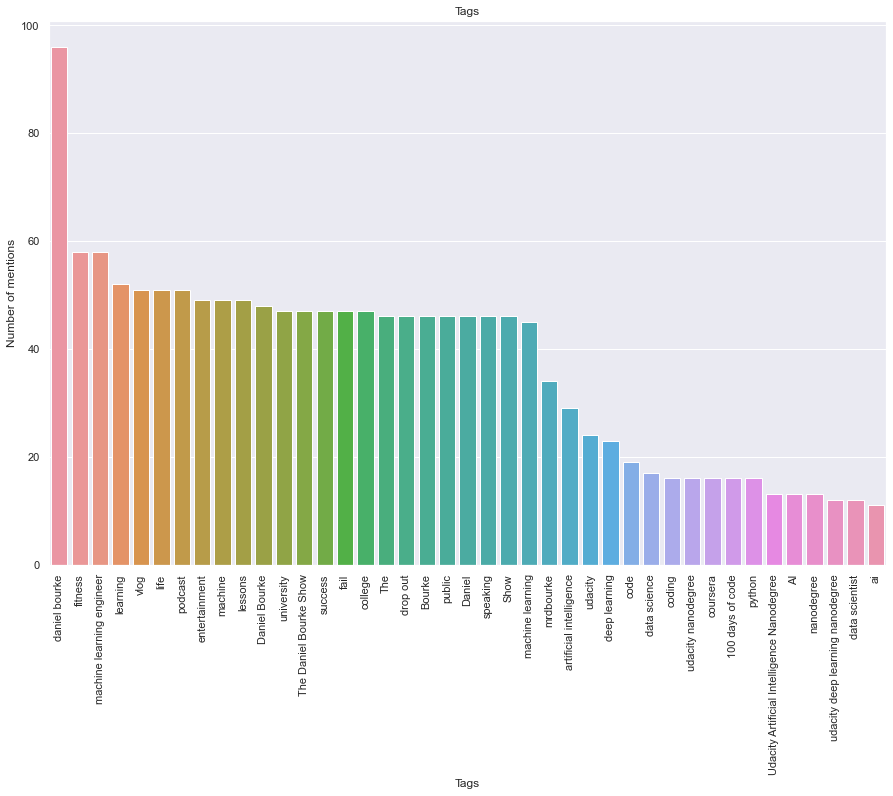

In [20]:
sns.set(style='darkgrid')
plt.figure(figsize=(15,10))

ax = sns.barplot(tagsAbove10.index, tagsAbove10.values)
ax.set(title='Tags',xlabel='Tags', ylabel='Number of mentions')
ticks = ax.set_xticklabels(ax.get_xticklabels(),rotation=90) # if not assigned to a variable, then prints lots of text

We are using `map()` function. This essential does through every cell and applies the contents, which is a lambda function, which searches the tags or title for any of the words  `pat`.

We are also going to create another column within the same dataframe, `isMachineLearning`.

In [21]:
pat = r'.*(machine learning|data science|artificial intelligence|deep learning|code|machine|python|coding|code|udacity|coursera|data scientist|tensorflow).*$'

df1['isMachineLearning'] = df1['snippet.tags'].map(lambda x : bool(re.search(pat, str(x).lower())))|df1['snippet.title'].map(lambda x : bool(re.search(pat, str(x).lower())))
df1.head(20)

,snippet.title,snippet.tags,contentDetails.duration,statistics.viewCount,statistics.likeCount,statistics.dislikeCount,statistics.commentCount,snippet.publishedAt,snippet.description,snippet.publishedAt_REFORMATED,contentDetails.duration_REFORMATED,isMachineLearning
0,Data scientists should be more end-to-end | Ma...,"[machine learning monthly, how to get started ...",PT37M45S,1820.0,144.0,1.0,26.0,2020-10-10T13:50:35Z,Every month I review the latest and greatest r...,2020-10-10 13:50:35,0 days 00:37:45,True
1,What skills should you learn outside of machin...,"[machine learning engineer, daniel bourke, mac...",PT1H16M28S,3669.0,158.0,6.0,23.0,2020-10-05T05:22:14Z,Every month or so I do a livestream where I da...,2020-10-05 05:22:14,0 days 01:16:28,True
2,It's going to be a big (and fast) Summer of le...,"[machine learning monthly, machine learning en...",PT29M12S,23742.0,840.0,9.0,146.0,2020-09-19T05:23:13Z,From new Nvidia GPUs to using machine learning...,2020-09-19 05:23:13,0 days 00:29:12,True
3,How I'd start learning machine learning again ...,NaN,PT26M23S,36312.0,1829.0,29.0,157.0,2020-09-13T02:30:12Z,Three years ago I started studying machine lea...,2020-09-13 02:30:12,0 days 00:26:23,True
4,Building a Deep Learning PC,NaN,PT1H1M46S,10456.0,416.0,6.0,145.0,2020-09-06T10:58:18Z,I've been thinking about building my own deep ...,2020-09-06 10:58:18,0 days 01:01:46,True
5,The future will not be supervised... | Machine...,"[self supervised learning machine learning, ma...",PT26M28S,7658.0,295.0,2.0,38.0,2020-08-09T06:06:03Z,This month has been all about GPT3 and self-su...,2020-08-09 06:06:03,0 days 00:26:28,True
6,Are courses enough for a job? | Machine learni...,NaN,PT1H24M11S,8039.0,325.0,9.0,26.0,2020-08-06T00:29:48Z,"Let's talk machine learning, health, business ...",2020-08-06 00:29:48,0 days 01:24:11,True
7,What does a head of data science look for in a...,"[ken jee, daniel bourke, what questions get as...",PT1H1M6S,10469.0,495.0,9.0,36.0,2020-07-16T03:15:13Z,Ken Jee is the head of data science at Scouts ...,2020-07-16 03:15:13,0 days 01:01:06,True
8,2020 Machine Learning Roadmap,"[machine learning field guide, machine learnin...",PT2H37M14S,275363.0,13845.0,168.0,584.0,2020-07-12T15:00:12Z,Getting into machine learning is quite the adv...,2020-07-12 15:00:12,0 days 02:37:14,True
9,One Neural Network to Rule Them All (and more)...,"[zero to mastery, machine learning monthly, wh...",PT32M2S,5607.0,198.0,0.0,62.0,2020-07-06T10:30:06Z,Every month I write an article called Machine ...,2020-07-06 10:30:06,0 days 00:32:02,True


In [22]:
NaNs = df1['isMachineLearning'].isna().sum()
Total_MLvids =  df1['isMachineLearning'].sum()
Total_nonMLvids = (df1['isMachineLearning']==False).sum()
Total = Total_MLvids + Total_nonMLvids

print('Total NaN: ', NaNs)
print('Total ML videos: ', Total_MLvids)
print('Total non-ML videos: ', Total_nonMLvids)
print('Videos in total: ', Total)

print('Percentage of ML videos: {}%'.format(str(round(((Total_MLvids*100)/Total),2))))

Total NaN:  0
Total ML videos:  178
Total non-ML videos:  78
Videos in total:  256
Percentage of ML videos: 69.53%


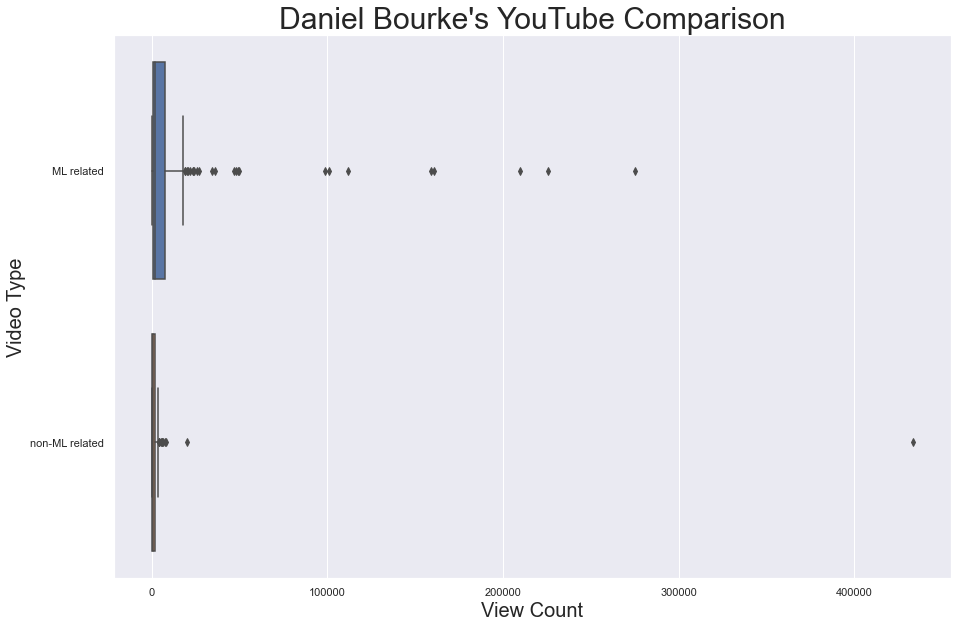

In [23]:
MLds = df1[df1['isMachineLearning']==True]['statistics.viewCount'] # create dataseries of view counts for ML related videos
nonMLds = df1[df1['isMachineLearning']==False]['statistics.viewCount']

d = {'ML related': MLds.values, 'non-ML related': nonMLds.values} # creating a dictionary to title data
d = pd.DataFrame.from_dict(d, orient='index') # dataseries have different shape or 'sizes', pandas will add NaN to make series same size

data = d.transpose()

plt.figure(figsize=(15,10))
sns.set(style='darkgrid')
ax = sns.boxplot(data=data, orient='h')

ax.set_title("Daniel Bourke's YouTube Comparison", fontsize=30)
ax.set_xlabel('View Count', fontsize=20)
ax.set_ylabel('Video Type', fontsize=20)


plt.show()

This isn't too useful as the data is so spaced out. What we can notice here is that view count show an exponential pattern. This is the 'viral' effect. What I can do is flatten this down by using the natural logarithm. I can apply this using `np.nlog()`

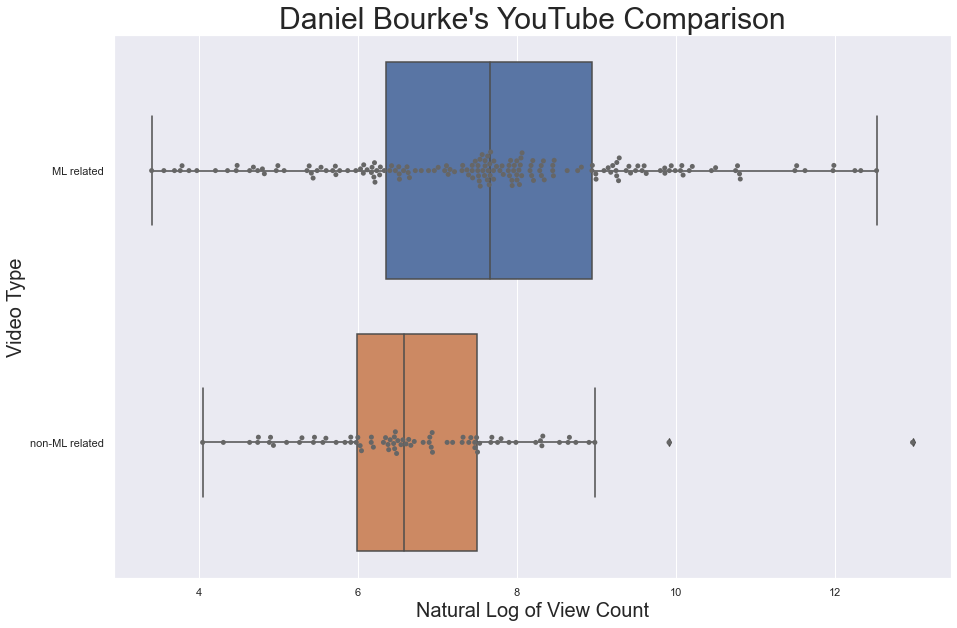

In [24]:
d = {'ML related': np.log(MLds.values), 'non-ML related': np.log(nonMLds.values)} # applying natural log
d = pd.DataFrame.from_dict(d, orient='index')

data = d.transpose()

plt.figure(figsize=(15,10))
sns.set(style='darkgrid')
ax = sns.boxplot(data=data, orient='h')

ax.set_title("Daniel Bourke's YouTube Comparison", fontsize=30)
ax.set_xlabel('Natural Log of View Count', fontsize=20)
ax.set_ylabel('Video Type', fontsize=20)

ax = sns.swarmplot(data=data, orient='h', color='0.4')

plt.show()

We can also view this as a distribution type plot, showing the two groups. Another thing to note is that the groups have different sizes.

This next plot normalises the different groups as though they are the same size.

C:\Users\Shiva\miniconda3\envs\shivan_environment\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Shiva\miniconda3\envs\shivan_environment\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


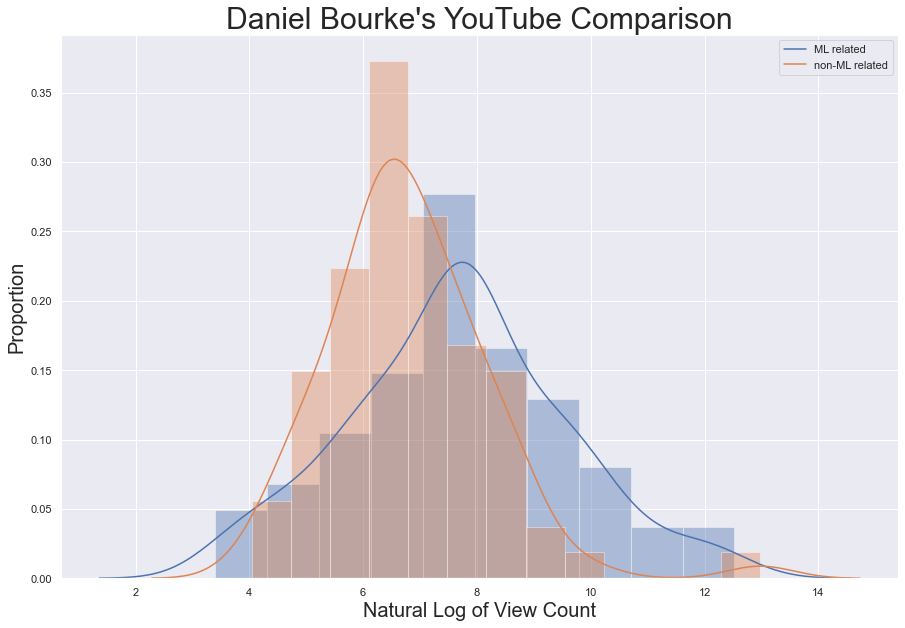

In [25]:
d = {'ML related': np.log(MLds.values), 'non-ML related': np.log(nonMLds.values)}
d = pd.DataFrame.from_dict(d, orient='index')

data = d.transpose()

plt.figure(figsize=(15,10))
sns.set(style='darkgrid')

ax = sns.distplot(data['ML related'])
ax = sns.distplot(data['non-ML related'])


ax.set_title("Daniel Bourke's YouTube Comparison", fontsize=30)
ax.set_xlabel('Natural Log of View Count', fontsize=20)
ax.set_ylabel('Proportion', fontsize=20)

plt.legend(data)

plt.show()

An interesting fact is that Daniel Bourke's most popular video is not about machine learning. This may change in the future.

In [26]:
df1.sort_values(by='statistics.viewCount', ascending=False).head(10)

,snippet.title,snippet.tags,contentDetails.duration,statistics.viewCount,statistics.likeCount,statistics.dislikeCount,statistics.commentCount,snippet.publishedAt,snippet.description,snippet.publishedAt_REFORMATED,contentDetails.duration_REFORMATED,isMachineLearning
72,"I didn't eat food for 4 days, here's what happ...","[what is like to do an extended fast?, intermi...",PT45M41S,433037.0,4994.0,503.0,952.0,2019-09-15T12:06:12Z,"Last month, I did my first extended fast. I’d ...",2019-09-15 12:06:12,0 days 00:45:41,False
8,2020 Machine Learning Roadmap,"[machine learning field guide, machine learnin...",PT2H37M14S,275363.0,13845.0,168.0,584.0,2020-07-12T15:00:12Z,Getting into machine learning is quite the adv...,2020-07-12 15:00:12,0 days 02:37:14,True
11,How I passed the TensorFlow Developer Certific...,NaN,PT26M25S,225769.0,7893.0,94.0,555.0,2020-06-10T02:06:17Z,"At the start of May, I decided to take the Ten...",2020-06-10 02:06:17,0 days 00:26:25,True
90,How I got Google Cloud Professional Data Engin...,"[google cloud, google cloud professional data ...",PT20M,209641.0,4510.0,159.0,324.0,2019-04-27T12:20:52Z,I've been upskilling myself on engineering dat...,2019-04-27 12:20:52,0 days 00:20:00,True
37,Don't learn machine learning,"[machine learning engineer, how to learn machi...",PT17M57S,160891.0,3649.0,418.0,301.0,2020-03-30T04:23:56Z,"Should you learn machine learning? Yes, you sh...",2020-03-30 04:23:56,0 days 00:17:57,True
127,A Day In The Life Of A Machine Learning Engine...,"[machine learning engineer, a day in the life ...",PT9M7S,159237.0,1904.0,393.0,174.0,2018-07-21T14:32:52Z,A day in the life of what it's like to be a ma...,2018-07-21 14:32:52,0 days 00:09:07,True
17,I got my machine learning model deployed! | Ai...,"[machine learning project, what does a machine...",PT22M21S,111903.0,2059.0,38.0,135.0,2020-04-16T13:00:27Z,"After a few days of fiddling around, I managed...",2020-04-16 13:00:27,0 days 00:22:21,True
73,5 Beginner Friendly Steps to Learn Machine Lea...,"[how to learn machine learning with python, ho...",PT13M42S,100732.0,5982.0,48.0,365.0,2019-09-15T12:00:59Z,This video breaks down practical steps on how ...,2019-09-15 12:00:59,0 days 00:13:42,True
75,These books will help you learn machine learning,"[the best books for machine learning, best boo...",PT10M23S,98500.0,4478.0,30.0,199.0,2019-08-18T10:04:03Z,Machine learning engineer Daniel Bourke shares...,2019-08-18 10:04:03,0 days 00:10:23,True
106,Code with me (live): How to make your first Ka...,"[machine learning engineer kaggle, kaggle data...",PT2H5M45S,49539.0,1205.0,9.0,144.0,2018-12-02T05:03:43Z,Let's explore the Kaggle Titanic data and make...,2018-12-02 05:03:43,0 days 02:05:45,True


Finally, I'm interested in the trends over time. We can do this my linear regression and then extracting some statistics as well.

C:\Users\Shiva\miniconda3\envs\shivan_environment\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Shiva\miniconda3\envs\shivan_environment\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


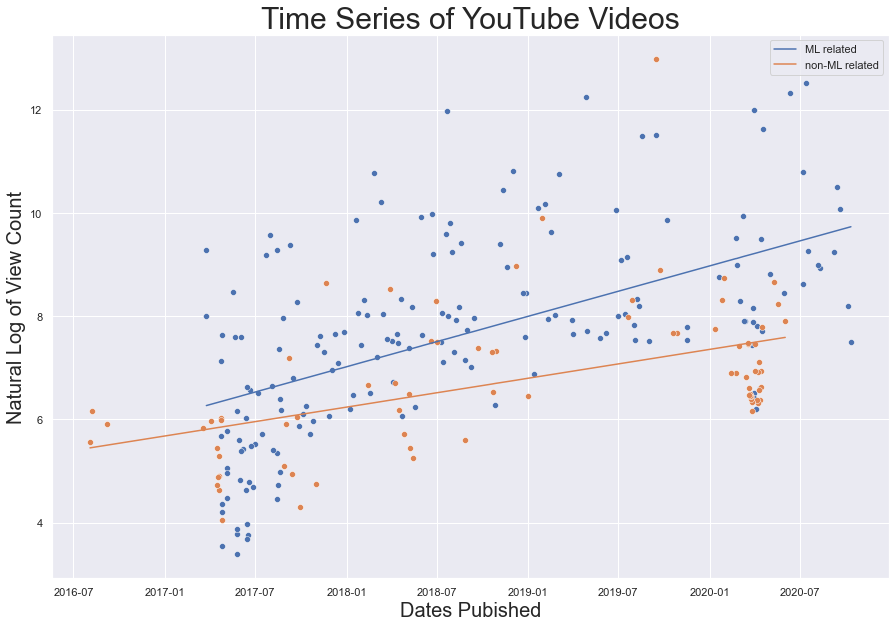

In [28]:
from sklearn.linear_model import LinearRegression

def perform_reg(X, Y):
    model = LinearRegression()
    L = len(X.values)
    X = X.values.reshape(-1,1)
    Y = Y
    model.fit(X, Y)
    return model.predict(X)

df1['statistics.viewCount_LOG'] = df1['statistics.viewCount'].apply(lambda x : np.log(x))
MLdf = df1[df1['isMachineLearning']==True]
nonMLdf = df1[df1['isMachineLearning']==False]

d = {'ML related': MLdf, 'non-ML related': nonMLdf}

MLdf['statistics.viewCount_REG'] = perform_reg(MLdf['snippet.publishedAt_REFORMATED'].map(datetime.toordinal), MLdf['statistics.viewCount_LOG'])
nonMLdf['statistics.viewCount_REG'] = perform_reg(nonMLdf['snippet.publishedAt_REFORMATED'].map(datetime.toordinal), nonMLdf['statistics.viewCount_LOG'])


plt.figure(figsize=(15,10))
sns.set(style='darkgrid')

ax = sns.scatterplot(data=MLdf,x='snippet.publishedAt_REFORMATED', y='statistics.viewCount_LOG')
ax = sns.scatterplot(data=nonMLdf,x='snippet.publishedAt_REFORMATED', y='statistics.viewCount_LOG')
ax = sns.lineplot(data=MLdf,x='snippet.publishedAt_REFORMATED', y='statistics.viewCount_REG')
ax = sns.lineplot(data=nonMLdf,x='snippet.publishedAt_REFORMATED', y='statistics.viewCount_REG')


ax.set_title("Time Series of YouTube Videos", fontsize=30)
ax.set_xlabel('Dates Pubished', fontsize=20)
ax.set_ylabel('Natural Log of View Count', fontsize=20)

plt.legend(d)

plt.show()

We can see a general upward trend in the upward trend in his view count. We can also see the consistency Daniel Bourke has put into making his channel. Consistency is key.

Another point is that we see in general greater potential in the machine learning video related content compared to the non-machine learning content.

Futher to this, we can obtain the acual gradient of the best-fit line as well as the Pearson correlation coefficient, which is a way of telling us how well the data fits with this best fit line.

In [29]:
import scipy.stats

# calculating the slope
resultsML = scipy.stats.linregress(MLdf['snippet.publishedAt_REFORMATED'].map(datetime.toordinal), MLdf['statistics.viewCount_LOG'])
resultsNonML = scipy.stats.linregress(nonMLdf['snippet.publishedAt_REFORMATED'].map(datetime.toordinal), nonMLdf['statistics.viewCount_LOG'])

print('ML video slope: '  + str(resultsML.slope).rjust(45))
print('Non-ML related video slope: ' + str(resultsNonML.slope).rjust(33))
print(' ')

ML_r = scipy.stats.pearsonr(MLdf['snippet.publishedAt_REFORMATED'].map(datetime.toordinal), MLdf['statistics.viewCount_LOG'])[0]
nonML_r = scipy.stats.pearsonr(nonMLdf['snippet.publishedAt_REFORMATED'].map(datetime.toordinal), nonMLdf['statistics.viewCount_LOG'])[0]

# calculating the coefficient
print('ML video correlation coefficient: '  + str(ML_r).rjust(24))
print('Non-ML video correlation coefficient: ' + str(nonML_r).rjust(20))

ML video slope:                         0.0026763138487074243
Non-ML related video slope:             0.0015324695615027768
 
ML video correlation coefficient:       0.5562788420820676
Non-ML video correlation coefficient:   0.4933482154275735


## Bonus

I got a mention on Daniel Bourke machine learning monthly video for September 2020. That's really exciting!

He did mention he wanted to keep his video shorter, but I wondered in video length correlated with his view count.

Let's see.

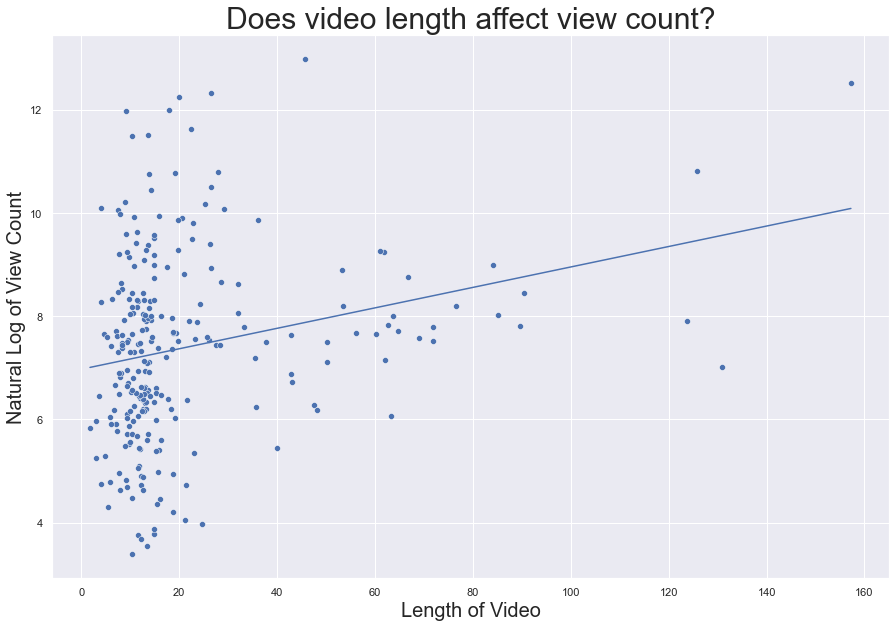

In [51]:
df1.dtypes

df1['contentDetails.duration_REFORMATED_FLOAT'] = df1['contentDetails.duration_REFORMATED'].apply(lambda x: (x.seconds/60))
df1['statistics.viewCount_LOG_REG_DURA'] = perform_reg(df1['contentDetails.duration_REFORMATED_FLOAT'], df1['statistics.viewCount_LOG'])

plt.figure(figsize=(15,10))
sns.set(style='darkgrid')

ax = sns.scatterplot(data=df1,x='contentDetails.duration_REFORMATED_FLOAT', y='statistics.viewCount_LOG')
ax = sns.lineplot(data=df1,x='contentDetails.duration_REFORMATED_FLOAT', y='statistics.viewCount_LOG_REG_DURA')

ax.set_title("Does video length affect view count?", fontsize=30)
ax.set_xlabel('Length of Video', fontsize=20)
ax.set_ylabel('Natural Log of View Count', fontsize=20)

plt.show()

In [61]:
resultsDura = scipy.stats.linregress(df1['contentDetails.duration_REFORMATED_FLOAT'], df1['statistics.viewCount_LOG'])
dura_r = scipy.stats.pearsonr(df1['contentDetails.duration_REFORMATED_FLOAT'], df1['statistics.viewCount_LOG'])[0]

print('Slope:\n', str(resultsDura.slope))
print('Correlation:\n', dura_r)

Slope:
 0.019813619113290565
Correlation:
 0.24241016648568642


In [56]:
#some of Daniel Bourke's longest videos

df1[df1['contentDetails.duration_REFORMATED_FLOAT'] > 120]

,snippet.title,snippet.tags,contentDetails.duration,statistics.viewCount,statistics.likeCount,statistics.dislikeCount,statistics.commentCount,snippet.publishedAt,snippet.description,snippet.publishedAt_REFORMATED,contentDetails.duration_REFORMATED,isMachineLearning,statistics.viewCount_LOG,contentDetails.duration_REFORMATED_FLOAT,statistics.viewCount_LOG_REG_DURA
8,2020 Machine Learning Roadmap,"[machine learning field guide, machine learnin...",PT2H37M14S,275363.0,13845.0,168.0,584.0,2020-07-12T15:00:12Z,Getting into machine learning is quite the adv...,2020-07-12 15:00:12,0 days 02:37:14,True,12.525846,157.233333,10.090250
53,Replicating Airbnb's Machine Learning Powered ...,"[machine learning engineer, daniel bourke, mac...",PT2H3M42S,2714.0,72.0,0.0,8.0,2020-03-11T07:04:10Z,I read an article the other which described ho...,2020-03-11 07:04:10,0 days 02:03:42,True,7.906179,123.700000,9.425833
106,Code with me (live): How to make your first Ka...,"[machine learning engineer kaggle, kaggle data...",PT2H5M45S,49539.0,1205.0,9.0,144.0,2018-12-02T05:03:43Z,Let's explore the Kaggle Titanic data and make...,2018-12-02 05:03:43,0 days 02:05:45,True,10.810516,125.750000,9.466451
116,Artificial Intelligence in Business Keynote at...,"[artificial intelligence, machine learning eng...",PT2H10M56S,1106.0,37.0,2.0,18.0,2018-09-08T04:17:52Z,Athon and I went and presented a talk about ho...,2018-09-08 04:17:52,0 days 02:10:56,True,7.008505,130.933333,9.569151


## Conclusion

I think I will leave it there. There is lots of work that can be done but this is the limit of my skills.

I hope to revisit this in the future as I get better and see what more I can do.

What I would like to improve upon is:
- an ability to classify videos
- this is really an analysis, no machine learning was used

Thank you for reading through this, please get in touch. I'm always looking to improve.
